In [17]:
import pandas as pd
import numpy as np
from pycoingecko import CoinGeckoAPI
import matplotlib.pyplot as plt
import mplfinance as mpf

In [18]:
cg = CoinGeckoAPI()
ohlc = cg.get_coin_ohlc_by_id(id = "bitcoin", vs_currency = "usd", days = "30")
df = pd.DataFrame(ohlc, columns = ['timestamp', 'open', 'high', 'low', 'close'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

df['SMA_5'] = df['close'].rolling(window=5).mean()
df['SMA_20'] = df['close'].rolling(window=20).mean()

delta = df['close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

rs = avg_gain / avg_loss.replace(0, np.nan)
df['RSI_14'] = 100 - (100 / (1 + rs))
print(df[['timestamp', 'close', 'SMA_5', 'SMA_20', 'RSI_14']].tail(10))

              timestamp    close    SMA_5    SMA_20     RSI_14
170 2026-01-31 08:00:00  83412.0  83751.6  85994.90  25.726106
171 2026-01-31 12:00:00  82808.0  83728.6  85684.50  27.249150
172 2026-01-31 16:00:00  81299.0  83114.8  85296.10  21.708069
173 2026-01-31 20:00:00  77687.0  81823.8  84685.65  17.454308
174 2026-02-01 00:00:00  78726.0  80786.4  84152.20  27.825240
175 2026-02-01 04:00:00  78770.0  79858.0  83621.10  29.664430
176 2026-02-01 08:00:00  78380.0  78972.4  83082.00  25.052394
177 2026-02-01 12:00:00  78668.0  78446.2  82620.60  32.028671
178 2026-02-01 16:00:00  77476.0  78404.0  82080.95  27.338005
179 2026-02-01 20:00:00  77210.0  78100.8  81558.50  24.527480


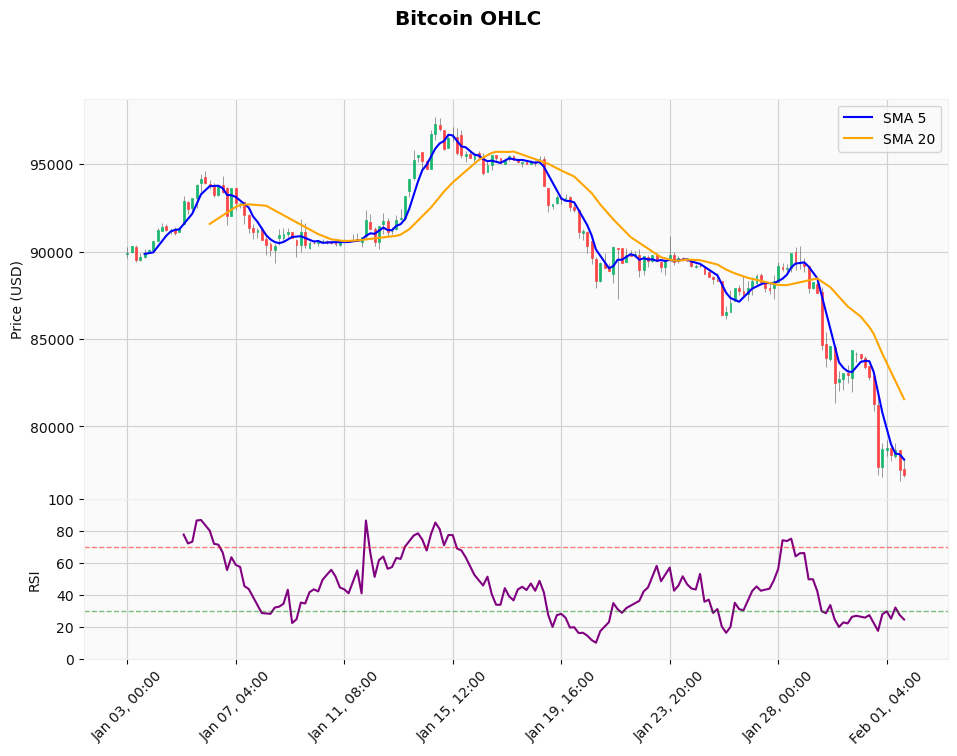

In [19]:
df.set_index('timestamp', inplace=True)

apds = [
    mpf.make_addplot(df['SMA_5'], color='blue', width=1.5, panel=0, label='SMA 5'),
    mpf.make_addplot(df['SMA_20'], color='orange', width=1.5, panel=0, label='SMA 20'),
    mpf.make_addplot(df['RSI_14'], color='purple', width=1.5, panel=1, ylabel='RSI', 
                     ylim=(0, 100))
]


figs, axes = mpf.plot(df, type='candle', style='yahoo', title = 'Bitcoin OHLC', volume = False, ylabel = 'Price (USD)', returnfig=True, addplot=apds, figsize=(12,8))
axes[0].yaxis.tick_left()
axes[0].yaxis.set_label_position("left")
axes[2].yaxis.tick_left()
axes[2].yaxis.set_label_position("left")
axes[2].axhline(70, color='red', linestyle='--', linewidth=1, alpha = 0.5)
axes[2].axhline(30, color='green', linestyle='--', linewidth=1, alpha = 0.5)
plt.show()

Some linear regresson

Predicted close for next day: $85818.96


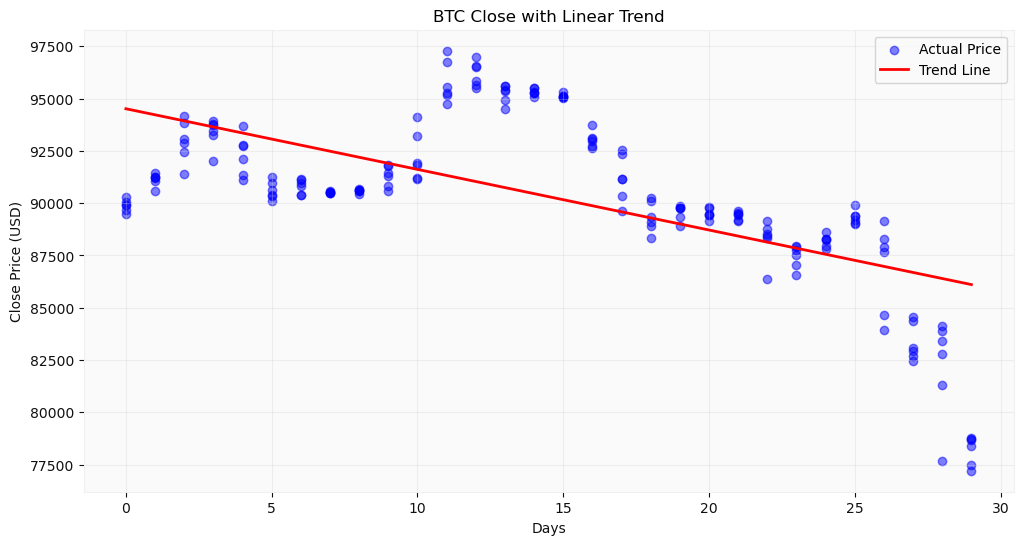

In [20]:
from sklearn.linear_model import LinearRegression

df_temp = df.reset_index()
df_temp['day'] = (df_temp['timestamp'] - df_temp['timestamp'].min()).dt.days
X = df_temp['day'].values.reshape(-1, 1)
y = df_temp['close'].values

model = LinearRegression()
model.fit(X, y)
next_day = np.array([[df_temp['day'].max() + 1]])
predicted_close = model.predict(next_day)[0]
print(f"Predicted close for next day: ${predicted_close:.2f}")
plt.figure(figsize=(12, 6))
plt.scatter(df_temp['day'], df_temp['close'], color='blue', alpha=0.5, label='Actual Price')
plt.plot(df_temp['day'], model.predict(X), color='red', linewidth=2, label='Trend Line')
plt.xlabel('Days')
plt.ylabel('Close Price (USD)')
plt.title('BTC Close with Linear Trend')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()